# **B2B Pricing**
B2B Data from a firm selling a marketing automation software.

Two main channels are used to sell, i.e., (1) directly after lead generation efforts (e.g., trade-shows, email marketing campaign, website of the company) and (2) indirectly through "partners".

The company has two types of "products", i.e., (1) cloud products and (2) "on-premise" products

The data set has information about:

Dates at which each lead was generated and closed
Whether it's a "new logo" or not
Type of product sought
Deal was won or lost
Billing plan (e.g., one year vs. three years)
Annual Contract Value (ACV)
Amount
Discount
# Net Amount (i.e., amount - discount)

In [16]:
import matplotlib.pyplot as plt#
import numpy as np
import math
import scipy
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)
import pandas as pd # Load Pandas which is a Python package to manipulate data; call it 'pd'
import numpy as np # Load Numpy which is a Python package to manipulate to do math, call it 'np'
url = 'https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv' #This is the link to my github profile with the data
df = pd.read_csv(url)#this load the data from the URL define above
df.head() #just looking at the data
#df['Stage'].unique()

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100


Lost    971
Won     534
Name: Stage, dtype: int64

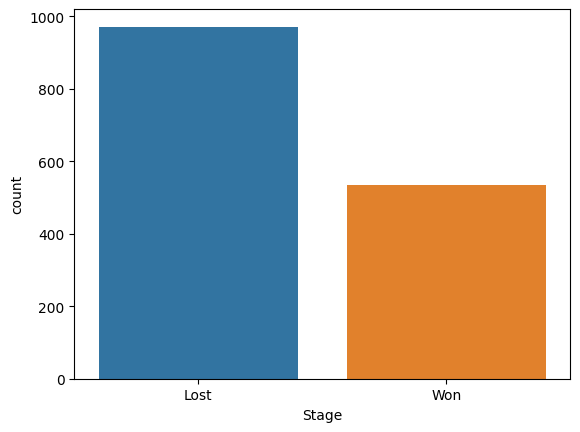

In [17]:
df['Stage']=np.where(df['Stage'] =='Closed Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Not Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed - Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Lost - Not Renewing', 'Lost', df['Stage'])
sns.countplot(x='Stage',data=df)
df['Stage'].value_counts()

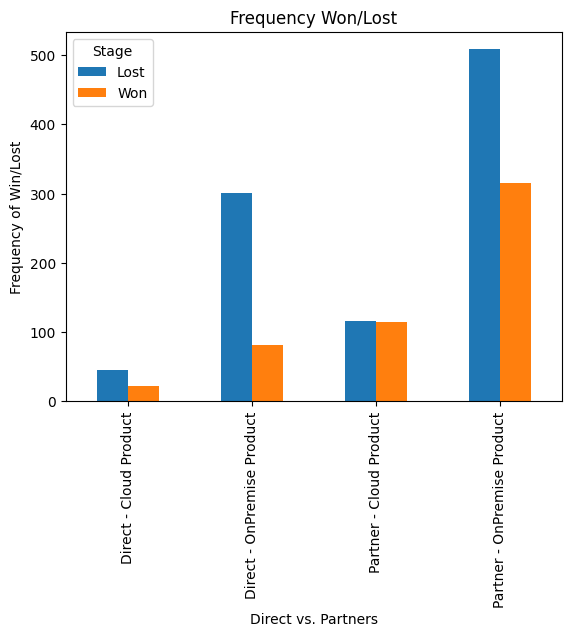

In [18]:
%matplotlib inline
pd.crosstab(df.Type,df.Stage).plot(kind='bar')
plt.title('Frequency Won/Lost')
plt.xlabel('Direct vs. Partners')
plt.ylabel('Frequency of Win/Lost')
plt.savefig('WinLost')

In [19]:
#create binary variables
df['Partner cloud']=np.where(df['Type'] =='Partner - Cloud Product', 1.0,0.0)
df['Partner prem']=np.where(df['Type'] =='Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud']=np.where(df['Type'] =='Direct - Cloud Product', 1.0,0.0)
df['Direct prem']=np.where(df['Type'] =='Direct - OnPremise Product', 1.0, 0.0)
#making sure entries are numeric.
df['amount']=pd.to_numeric(df[' Amount '],errors='coerce')
df['net amount']=pd.to_numeric(df[' Net Amount '],errors='coerce')
df['discount']=df['amount']-df['net amount']
df['depth']=df['discount']/df['amount']
df.drop(' Discount Amount ',axis=1)
df.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'ID', 'Type'],axis=1);
round(df.groupby('Type').mean().drop(['ID','Partner cloud', 'Partner prem', 'Direct cloud', 'Direct prem'],axis=1),2)

<ipython-input-19-6bc88c91544c>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  round(df.groupby('Type').mean().drop(['ID','Partner cloud', 'Partner prem', 'Direct cloud', 'Direct prem'],axis=1),2)


,New Logo,amount,net amount,discount,depth
Type,,,,,
Direct - Cloud Product,0.72,109213.25,87843.81,21369.45,0.16
Direct - OnPremise Product,0.35,52366.70,44466.40,7900.30,0.06
Partner - Cloud Product,0.77,152230.87,120068.63,32162.24,0.18
Partner - OnPremise Product,0.41,75928.42,63234.93,12679.17,0.10


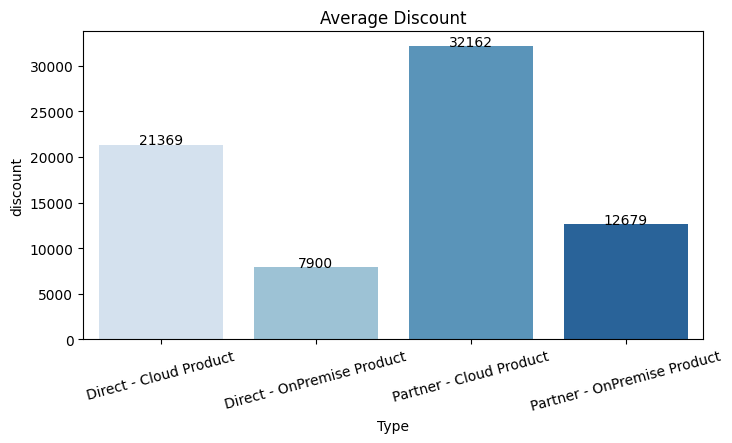

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
avg_discount = df.groupby('Type', as_index=False)['discount'].mean()

# Customizing the plot
fig = sns.barplot(x='Type', y='discount', data=avg_discount, palette='Blues')
fig.set_title("Average Discount")
fig.set_xticklabels(fig.get_xticklabels(), rotation=15)

# Adding value labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{int(p.get_height()):d}', ha='center')

plt.show()


In [ ]:
# Checking to see if the hypothesis that salespersons give deeper discounts in end of quater or not

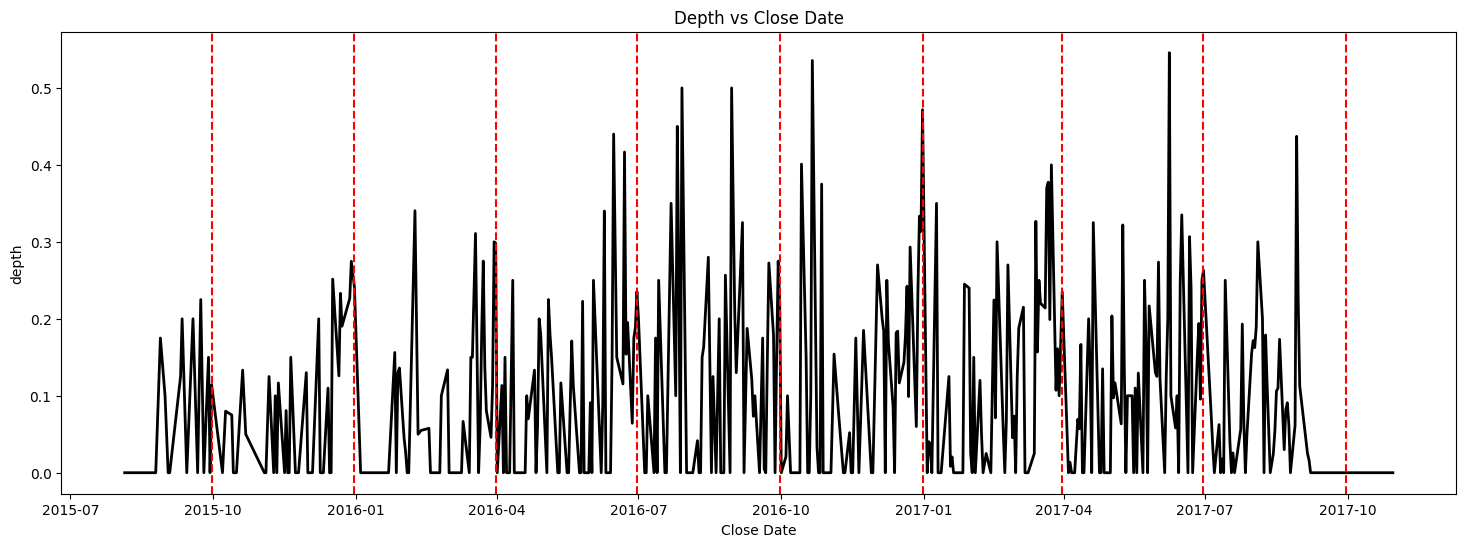

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'Close Date' column to datetime
df['Close Date'] = pd.to_datetime(df['Close Date'])

# Plot depth vs close date with increased width and black color
plt.figure(figsize=(18, 6))
sns.lineplot(x='Close Date', y='depth', data=df, errorbar=None, color='black', linewidth=2).set_title("Depth vs Close Date")

# Calculate and plot the end of each quarter
quarter_end_dates = pd.date_range(start=df['Close Date'].min(), end=df['Close Date'].max(), freq='Q')
for date in quarter_end_dates:
    plt.axvline(date, color='red', linestyle='--')

plt.show()


In [ ]:
# Based on EDA, there seems to be a spike at the end of quarter as the depths are not necessarily increasing towards the end of the quarter

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Convert 'Close Date' column to datetime format
df['Date'] = pd.to_datetime(df['Close Date'])

# Creating a new column for detecting the end of a quarter
df['Quarter_End'] = np.where((df['Date'].dt.month % 3 == 0) & (df['Date'].dt.day >= 14), 1, 0)

# Creating separate datasets for hypothesis testing
end_of_quarter_data = df.loc[df['Quarter_End'] == 1, 'depth']
non_end_of_quarter_data = df.loc[df['Quarter_End'] == 0, 'depth']

# Dropping any missing values
end_of_quarter_discounts = end_of_quarter_data.dropna()
non_end_of_quarter_discounts = non_end_of_quarter_data.dropna()

# Performing a t-test to examine the end-of-quarter effect
t_stat, p_value, _ = sm.stats.ttest_ind(end_of_quarter_discounts, non_end_of_quarter_discounts)

# Printing the results of the hypothesis test
print("\nHypothesis Test Results")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}\n")



Hypothesis Test Results
T-statistic: 15.045611101889726
P-value: 1.177711608366997e-47



In [ ]:
# It is clear that sales people give discounts towards the end of quarter particularly the last 14 days based on the significant p-value from the t-test

In [25]:
#Splitting the dataset into test train set
# We will keep a 70-30 split for estimation and hold out dataset
from sklearn.model_selection import train_test_split
df.sort_values(by = 'ID', inplace=True)
train_df, hold_out_df = train_test_split(df, test_size = 0.3, shuffle=False)

In [26]:
train_df.drop(['ID'],axis=1,inplace=True)
train_df

,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,Date,Quarter_End
0,2017-05-26,5/4/17,1,Direct - Cloud Product,Lost,3 Years,431370,,225000,225000,0.0,0.0,1.0,0.0,225000.0,225000.0,0.0,0.00,2017-05-26,0
1,2016-12-29,11/29/16,1,Partner - OnPremise Product,Won,3 Years,22050,80850,147000,66150,0.0,1.0,0.0,0.0,147000.0,66150.0,80850.0,0.55,2016-12-29,1
2,2016-12-29,12/9/16,1,Partner - Cloud Product,Won,3 Years,32750,43200,96000,52800,1.0,0.0,0.0,0.0,96000.0,52800.0,43200.0,0.45,2016-12-29,1
3,2016-09-09,4/20/16,1,Direct - Cloud Product,Won,4 Years,36694,44800,128000,83200,0.0,0.0,1.0,0.0,128000.0,83200.0,44800.0,0.35,2016-09-09,0
4,2016-09-22,9/1/16,1,Partner - OnPremise Product,Won,3 Years,18700,9900,66000,56100,0.0,1.0,0.0,0.0,66000.0,56100.0,9900.0,0.15,2016-09-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,2017-03-17,8/7/16,0,Partner - OnPremise Product,Lost,3 Years,49000,NaN,147000,147000,0.0,1.0,0.0,0.0,147000.0,147000.0,0.0,0.00,2017-03-17,1
1049,2017-06-12,10/4/16,1,Partner - OnPremise Product,Lost,Annual,49000,NaN,49000,49000,0.0,1.0,0.0,0.0,49000.0,49000.0,0.0,0.00,2017-06-12,0
1050,2017-03-28,10/5/16,1,Partner - Cloud Product,Won,3 Years,187171,NaN,375000,375000,1.0,0.0,0.0,0.0,375000.0,375000.0,0.0,0.00,2017-03-28,1
1051,2016-11-20,10/5/16,0,Partner - OnPremise Product,Lost,NaN,147000,NaN,147000,147000,0.0,1.0,0.0,0.0,147000.0,147000.0,0.0,0.00,2016-11-20,0


In [27]:
hold_out_df.drop(['ID'],axis=1,inplace=True)
hold_out_df

,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,Date,Quarter_End
1053,2017-08-17,8/17/17,1,Partner - Cloud Product,Lost,3 Years,66750,24750,225000,200250,1.0,0.0,0.0,0.0,225000.0,200250.0,24750.0,0.110000,2017-08-17,0
1054,2017-06-09,6/9/17,1,Direct - OnPremise Product,Lost,NaN,22000,NaN,22000,22000,0.0,0.0,0.0,1.0,22000.0,22000.0,0.0,0.000000,2017-06-09,0
1055,2017-08-18,6/9/17,1,Direct - OnPremise Product,Lost,NaN,22000,NaN,22000,22000,0.0,0.0,0.0,1.0,22000.0,22000.0,0.0,0.000000,2017-08-18,0
1056,2017-06-26,6/14/17,1,Direct - OnPremise Product,Lost,NaN,22000,NaN,22000,22000,0.0,0.0,0.0,1.0,22000.0,22000.0,0.0,0.000000,2017-06-26,1
1057,2017-08-24,6/23/17,1,Direct - Cloud Product,Lost,Annual,41000,,22000,22000,0.0,0.0,1.0,0.0,22000.0,22000.0,0.0,0.000000,2017-08-24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,2016-02-04,9/17/15,0,Direct - OnPremise Product,Lost,NaN,17900,NaN,17900,17900,0.0,0.0,0.0,1.0,17900.0,17900.0,0.0,0.000000,2016-02-04,0
1501,2016-10-04,2/5/16,0,Partner - OnPremise Product,Lost,NaN,60000,NaN,60000,60000,0.0,1.0,0.0,0.0,60000.0,60000.0,0.0,0.000000,2016-10-04,0
1502,2016-11-04,9/21/16,0,Direct - OnPremise Product,Lost,Annual,55000,20000,75000,55000,0.0,0.0,0.0,1.0,75000.0,55000.0,20000.0,0.266667,2016-11-04,0
1503,2017-09-06,5/24/17,1,Direct - OnPremise Product,Lost,NaN,32000,NaN,32000,32000,0.0,0.0,0.0,1.0,32000.0,32000.0,0.0,0.000000,2017-09-06,0


# **Mathematical Formulation**

\begin{equation}
p(Y=1|x)=\frac{e^{x'\beta}}{1+e^{x'\beta}}
\end{equation}

In our case 
\begin{equation}
x'\beta=\beta_0+\beta_1\times \text{Amount}+\beta_2 \times \text{Discount}
\end{equation}


In [31]:
#Changing billing plan variable

import pandas as pd

# Mapping dictionary for converting billing plan values
billing_plan_mapping = {
    'Years': '',
    'Annual': '1',
    'Quarterly': '0.33',
    '3 Months': '0.25',
    '9 Months': '0.75'
}

# Converting Billing Plan values to numeric
df['Billing Plan'] = df['Billing Plan'].replace(billing_plan_mapping)
df['Billing Plan'] = pd.to_numeric(df['Billing Plan'], errors='coerce')
df['Billing Plan'] = df['Billing Plan'].fillna(0)


In [38]:
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,...,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,Date,Quarter_End
0,1,2017-05-26,5/4/17,1,Direct - Cloud Product,Lost,0.0,431370,,225000,...,0.0,0.0,1.0,0.0,225000.0,225000.0,0.0,0.00,2017-05-26,0
1,2,2016-12-29,11/29/16,1,Partner - OnPremise Product,Won,0.0,22050,80850,147000,...,0.0,1.0,0.0,0.0,147000.0,66150.0,80850.0,0.55,2016-12-29,1
2,3,2016-12-29,12/9/16,1,Partner - Cloud Product,Won,0.0,32750,43200,96000,...,1.0,0.0,0.0,0.0,96000.0,52800.0,43200.0,0.45,2016-12-29,1
3,4,2016-09-09,4/20/16,1,Direct - Cloud Product,Won,0.0,36694,44800,128000,...,0.0,0.0,1.0,0.0,128000.0,83200.0,44800.0,0.35,2016-09-09,0
4,5,2016-09-22,9/1/16,1,Partner - OnPremise Product,Won,0.0,18700,9900,66000,...,0.0,1.0,0.0,0.0,66000.0,56100.0,9900.0,0.15,2016-09-22,1


In [40]:
#Building the model 
import statsmodels.api as sm
train_df['y']=np.where(train_df['Stage'] =='Won', 1.0,0.0)
y=train_df['y']
x2=train_df[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]
model2 = sm.Logit(y, x2, missing='drop')
model2.fit
type(model2)
result2=model2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.446205
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1004
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.3405
Time:                        19:26:25   Log-Likelihood:                -447.99
converged:                       True   LL-Null:                       -679.33
Covariance Type:            nonrobust   LLR p-value:                 9.134e-97
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount       6.714e-05    7.9e-06      8.501      0.000    5.17e-05    8.26e-05
amount        -4.888

In [41]:
#Probability predicted by estimation: matrix multiplication on the x matrix with the vector of parameter estimates
round(np.mean(np.exp(np.matmul(x2,result2.params))/(1+np.exp(np.matmul(x2,result2.params)))),2)

0.41

# **Price Optimization**


Using these results, I want to optimize on the price

\begin{equation}
R(p)=Proba(Y=1|p,d) \times (p-d)
\end{equation}

Provide a code to optimize on the list price $p$ and the discount $d$

In [ ]:
# It is given that amount is not to be optimized so we can directly optimize for discount

In [42]:
# Expected revenue for optimized discount
x = hold_out_df[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]
id = 0
id_max = len(hold_out_df)
exp_rev_c1 = np.empty(id_max)
while id <= id_max - 1:
  ut = np.matmul(x.iloc[id,1:7], result2.params[1:7])
  p = x.iloc[id,1]
  d = x.iloc[id,0]
  b = result2.params[0]
  exp_rev_c1[id] = (np.exp(ut+b*d)/(1+np.exp(ut+b*d)))*(p-d)
  id = id+1

revOpt = np.nan_to_num(exp_rev_c1)

In [43]:
#Here I compute the overall revenue improvement as a ratio.
hold_out_df['Revenue']=np.where(hold_out_df['Stage'] =='Won',hold_out_df['net amount'] ,0.0)
round(np.sum(revOpt)/np.sum(hold_out_df['Revenue']),2)#This is the ratio of the optimized expected revenue / actual revenues

1.03

In [ ]:
# Case 1 Unoptimized discount

In [50]:
hold_out_df['Unoptimized Revenue'] = revOpt
hold_out_fin= round(hold_out_df[['Type','discount','Revenue','Unoptimized Revenue']].groupby('Type').mean(), 2)
hold_out_fin['Unoptimized Discount Improved Revenue Ratio'] = round(hold_out_fin['Unoptimized Revenue']/hold_out_fin['Revenue'], 2)
hold_out_fin

,discount,Revenue,Unoptimized Revenue,Unoptimized Discount Improved Revenue Ratio
Type,,,,
Direct - Cloud Product,12115.42,16489.58,23503.44,1.43
Direct - OnPremise Product,7857.15,11342.09,10820.83,0.95
Partner - Cloud Product,38306.85,43209.85,51521.82,1.19
Partner - OnPremise Product,10553.15,25329.55,24048.34,0.95


In [54]:
# Expected revenue based on optimized discount
id = 0
id_max = len(hold_out_df)
z = np.empty(id_max)
exp_rev_c2 = np.empty(id_max)
while id <= id_max - 1:
  ut = np.matmul(x2.iloc[id,1:7], result2.params[1:7])
  p = x2.iloc[id,1]
  b = result2.params[0]
  def revD(d):
    return -(np.exp(ut+b*d)/(1+np.exp(ut+b*d)))*(p-d)
  sol = minimize_scalar(revD)
  z[id] = sol.x
  exp_rev_c2[id] = (np.exp(ut+b*z[id])/(1+np.exp(ut+b*z[id])))*(p-z[id])
  id = id+1

revOpt = np.nan_to_num(exp_rev_c2)

In [56]:
hold_out_df['Revenue']=np.where(hold_out_df['Stage'] =='Won',hold_out_df['net amount'] ,0.0)
round(np.sum(revOpt)/np.sum(hold_out_df['Revenue']),2)#This is the ratio of the optimized expected revenue / actual revenues

2.25

In [59]:
# Case 2 optimized discount
hold_out_df['Optimized Revenue'] = revOpt
hold_out_fin= round(hold_out_df[['Type','discount','Revenue','Optimized Revenue']].groupby('Type').mean(), 2)
hold_out_fin['Optimized Discount Improved Revenue Ratio'] = round(hold_out_fin['Optimized Revenue']/hold_out_fin['Revenue'], 2)
hold_out_fin

,discount,Revenue,Optimized Revenue,Optimized Discount Improved Revenue Ratio
Type,,,,
Direct - Cloud Product,12115.42,16489.58,61657.61,3.74
Direct - OnPremise Product,7857.15,11342.09,48135.11,4.24
Partner - Cloud Product,38306.85,43209.85,80713.77,1.87
Partner - OnPremise Product,10553.15,25329.55,43557.97,1.72


# As can be seen from the above tables, revenues are higher when we are optimized for discounts compared to when we are not optimizing for discounts. We can also see that the improvement ratio is also much higher when we are using optimized discount both overall lelevel and based on the product type as well. So we should focus on optimizing discounts based on our objective and depending on it focus on the indiviudal product types

In [ ]:
# As can be seen from the above tables, revenues are higher when we are optimized for discounts compared to when we are not optimizing for discounts. We can also see that the improvement ratio is also much higher when we are using optimized discount both overall lelevel and based on the product type as well. So we should focus on optimizing discounts based on our objective and depending on it focus on the indiviudal product types